## Data Preparation

The CSVs were exported form the Excel sheet "reach_nga_msna_clean_dataset_final.xlsx".

In [1]:
import csv
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt

First We read "clean-hh.csv" and get a basic overview.

In [10]:
res = []
features = []
values = []

with open("../data/clean-hh.csv","rt") as csvf:
  # read feature names
  reader = csv.reader(csvf,delimiter='@', quotechar='"')
  features = next(reader)
  
  # read length of each content value. (only needed to know whethre valueis filled or not)
  reader = csv.reader(csvf,delimiter='@', quotechar='"')
  values = np.array([[x for x in row] for row in reader])
  res = np.array(list(map(lambda r: list(map(len,r)),values)))

In [38]:
res.shape

(10655, 947)

In [4]:
__dr = stats.describe([len(row) for row in res])
print("We have %d rows with each having %d columns. They might be potentially empty." % (__dr.nobs, __dr.minmax[0]))

We have 10655 rows with each having 947 columns. They might be potentially empty.


In [5]:
binary=np.copy(res)
binary[res!=0] = 1

#sortedbin = np.sort(binary,axis=)

This image shows filled values with 1 and empty ones with 0. One can observe, that around 1/4 of the features have been answered only from few poeple. Let's further investigate this

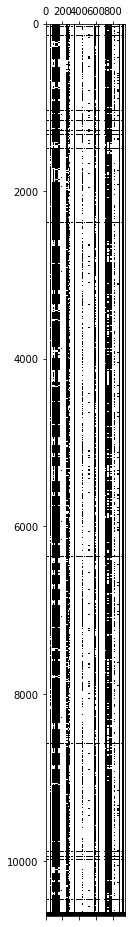

In [6]:
plt.matshow(binary,cmap=plt.cm.gray,vmin=0,vmax=1)
plt.show()

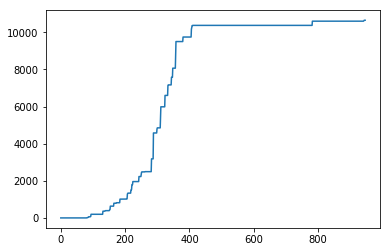

We see, that around 6/10 of the features are filled in by almost every data point. Only around 1% of the data has around zero features.


In [7]:
nEntries = np.sum(binary,axis=0)
featureSorter =  sorted(range(len(nEntries)),key=lambda k:nEntries[k],reverse=True)
plt.plot(sorted(nEntries))
plt.show()
print("We see, that around 6/10 of the features are filled in by almost every data point. Only around 1% of the data has around zero features.")

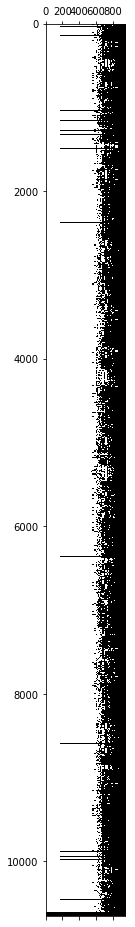

In [8]:
# sort columns so that the most distinguishing columns are first
cls_srt_binary = np.array([row[featureSorter] for row in binary])

plt.matshow(cls_srt_binary,cmap=plt.cm.gray,vmin=0,vmax=1)
plt.show()

In [9]:
# sort in a tree-like fashion
#sorted([[5,6],[8,4],[2,1]],key=lambda x:x[0]) # is a stable-sort according to reference!
sampleSorterA = np.arange(cls_srt_binary.shape[0])
aSSFS = np.copy(cls_srt_binary) # SSFS = sample sorted feature sorted
for i in reversed(list(range(cls_srt_binary.shape[1]))):
  sampleSorterA = sorted(sampleSorterA,key=lambda sampleIdx:aSSFS[sampleIdx][i])
aSSFS = aSSFS[sampleSorterA]

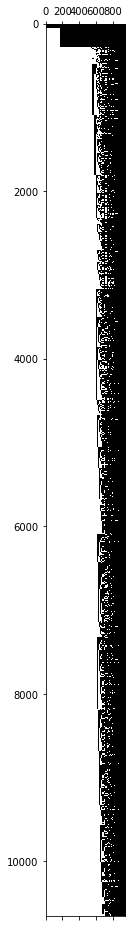

In [10]:
plt.matshow(aSSFS,cmap=plt.cm.gray,vmin=0,vmax=1)
plt.show()

The upper image shows the data with the features sorted in such a way, that most represented features are first and the least represented features are last (e.g. most empty answers). And then the samples are hierarchically sorted in such a way, that first (high) the samples without a feature appear - and then those with a feature. 

Alternatively, if we sort the samples starting form the first feature, then we get this:


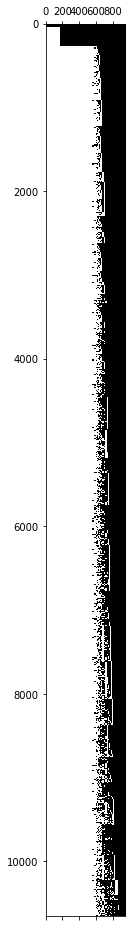

In [11]:
b = np.copy(cls_srt_binary)
for i in list(range(cls_srt_binary.shape[1])):
   b= sorted(b,key=lambda x:x[i])
  
print("Alternatively, if we sort the samples starting form the first feature, then we get this:")
plt.matshow(b,cmap=plt.cm.gray,vmin=0,vmax=1)
plt.show()

One way to effectively deal with this would be to simply discard the last 40% of the features and to work with the first 60%. In case one is afraid of information loss, one could investigate how much (non)-availability of the removed features are predicted by the first 60%. If they are not well predicted, then it may be not a big deal to remove them. *CAN BE DONE*

Another thing one can do, is to now look at these features that hvae been found to be so distinguishing. These are the features that are first on the bumps in the image. Let's take a look at them *DONE*

For all samples in the sorted sequence, the following plot shows the index of the first feature, where the sample contains no information anymore.


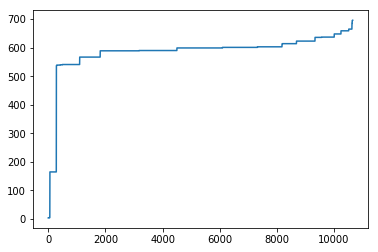

In [12]:
idxsSSFS = [np.where(row==0)[0][0] if len(np.where(row==0)[0]) > 0 else len(row)-1 for row in aSSFS]

print("For all samples in the sorted sequence, the following plot shows the index of the first feature, where the sample contains no information anymore.")
plt.plot(idxsSSFS)
plt.show()

In [13]:
from itertools import groupby
runlengthenc = [(k,len(list(g))) for k,g in groupby(idxsSSFS)]
cumrle = []
acc = len(idxsSSFS)
for k,l in runlengthenc:
  acc = acc - l
  cumrle.append((k,acc))

print("Sorted Data Samples:\n")

featuresFS = np.array(features)[featureSorter]

for fidxSSFS,nSamplesSSFS in cumrle:
  print("Features [0 to %3d] are answered by at least last %5d samples. Distingsh. feature %d is %s" % (fidxSSFS-1,nSamplesSSFS,fidxSSFS,featuresFS[fidxSSFS]))

Sorted Data Samples:

Features [0 to   3] are answered by at least last 10626 samples. Distingsh. feature 4 is WEIGHT_IND_LGA
Features [0 to   4] are answered by at least last 10601 samples. Distingsh. feature 5 is start
Features [0 to 164] are answered by at least last 10374 samples. Distingsh. feature 165 is Head of Household - Y/N
Features [0 to 536] are answered by at least last 10361 samples. Distingsh. feature 537 is What is the second priority need for your household overall?
Features [0 to 537] are answered by at least last 10359 samples. Distingsh. feature 538 is What is the third priority need for your household overall?
Features [0 to 538] are answered by at least last 10234 samples. Distingsh. feature 539 is WATER COST PREVIOUS DAY (Naira per liter)
Features [0 to 539] are answered by at least last 10162 samples. Distingsh. feature 540 is HOUSEHOLD WATER CONSUMPTOPN (liters per person per day)
Features [0 to 540] are answered by at least last  9558 samples. Distingsh. featu

The big chunk of filled data contains the following samples (from the sorted sample set) and the following features:

In [19]:
fidx,nSamples = cumrle[3]

bigChunkFlldFltrFeaturesSSFS = np.arange(fidx)
bigChunkFlldFltrSamplesSSFS = ((len(idxsSSFS)-nSamples)+np.arange(nSamples))

Samples from the big filled chunk:

In [20]:
print("Takes 30 seconds....")
tmp = values[sampleSorterA][:,featureSorter]
bigChunk = tmp[bigChunkFlldFltrSamplesSSFS][:,bigChunkFlldFltrFeaturesSSFS]
bigChunkFeatures = featuresFS[bigChunkFlldFltrFeaturesSSFS]

print(bigChunk[:10,:20])

Takes 30 seconds....
[['biusouthernbornonondisplaced' '0.6495216065' '0.592578711'
  '0.6645172403' '0.6682060516' '20180717T12:24:57744+01'
  '20180717T12:38:51351+01' 'Borno' 'biu' 'zarawuyaku' 'Zara kwagu'
  'kwaguinec' 'kwaguineczarawuyakubiusouthern bornoborno'
  'southern borno' 'Non-displaced'
  'Household has never been displaced from their village/area of origin since January 2009'
  'Yes, agrees to interview' '0' '0' '0']
 ['jeremmcandjereidp' '2.7105631119' '1.8773562774' '2.5056175788'
  '4.3826474997' '20180626T10:49:19755+01' '20180626T13:40:42532+01'
  'Borno' 'jere' 'mashamari' 'Mashimari' 'shokari'
  'shokarimashamarijeremmc and jereborno' 'mmc and jere'
  'Internally Displaced Persons (IDPs)'
  'Household displaced since January 2009 and currently is not living in their village/area of origin'
  'Yes, agrees to interview' '0' '0' '0']
 ['kalabalgeeastbornoidp' '0.7762024032' '1.8773562774' '2.5056175788'
  '1' '20180724T15:25:32778Z' '20180724T15:41:03972Z' 'Borno' 'k

Next step: Make values of big chunk more easily availible in python format. e.g. map them to numerical nominal/vector/ordinal values. document mapping between semantic value and numverical value. make small machine learning exmaple to showcase how it's used *NEXT-TODO*

In [21]:
print("Big Chunk is of shape %s and is indeed filled: number of empty cells is %d" % (bigChunk.shape,len(bigChunk[bigChunk==''])))

Big Chunk is of shape (10361, 537) and is indeed filled: number of empty cells is 0


In [22]:
print("Sample 1: ",bigChunk[0,5:10])
print("Features: ", featuresFS[5:10])

Sample 1:  ['20180717T12:24:57744+01' '20180717T12:38:51351+01' 'Borno' 'biu'
 'zarawuyaku']
Features:  ['start' 'end' 'State' 'LGA' 'Ward']


In [23]:
slc=np.arange(bigChunk.shape[1])[:]
for f,v in zip(bigChunkFeatures[slc],bigChunk[0,slc]):
  print("%s  -  %s..." % (v,f[:30]))

biusouthernbornonondisplaced  -  matching_weights...
0.6495216065  -  WEIGHT_HH_DOMAIN...
0.592578711  -  WEIGHT_HH_STATE...
0.6645172403  -  HH_ALL...
0.6682060516  -  WEIGHT_IND_LGA...
20180717T12:24:57744+01  -  start...
20180717T12:38:51351+01  -  end...
Borno  -  State...
biu  -  LGA...
zarawuyaku  -  Ward...
Zara kwagu  -  Village...
kwaguinec  -  CLUSTER NAME...
kwaguineczarawuyakubiusouthern bornoborno  -  cluster_id...
southern borno  -  Domain...
Non-displaced  -  Population Group...
Household has never been displaced from their village/area of origin since January 2009  -  Population Group - Status Chec...
Yes, agrees to interview  -  Consent...
0  -  Language - Zalidiva...
0  -  Language - Bobole...
0  -  Language - Bolewa...
0  -  Language - Chamba...
0  -  Language - French...
0  -  Language - Gobir...
0  -  Language - Igala...
0  -  Language - Igbo...
0  -  Language - Kilba...
0  -  Language - Mafa...
0  -  Language - Mandara...
0  -  Language - Manga...
0  -  Language -

Steps:

. for each feature, collect all the different possible output values
 (in choices sheet in the excel sheet) **TODO. for now I skip this step and extract the possible answers from the data variability iderctly**

. map each output value inside it's category to a consice number
 (this mapping should not introduce extra semantics and should be easily adaptable to new learned information)



In [24]:
featuresNAnswers = []
for fi,f in enumerate(bigChunkFeatures):
    uniquef = np.unique(bigChunk[:,fi])
    featuresNAnswers.append(len(uniquef))

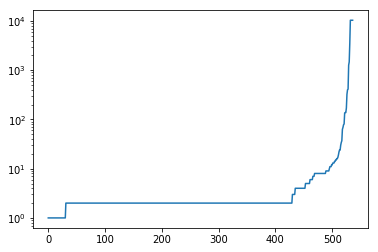

^ the size of the domain for the various features. Sorted from few to many on logarithmic scale.


In [25]:
plt.semilogy(sorted(featuresNAnswers))
plt.show()
print("^ the size of the domain for the various features. Sorted from few to many on logarithmic scale.")

In [34]:
mx = np.max(featuresNAnswers)
print("Features with ~1000 different answers")
print(bigChunkFeatures[np.where(featuresNAnswers>np.array([20]))[0]])

Features with ~1000 different answers
['matching_weights' 'WEIGHT_HH_DOMAIN' 'WEIGHT_IND_LGA' 'start' 'end'
 'LGA' 'Ward' 'Village' 'CLUSTER NAME' 'cluster_id'
 'TOTAL QUANTITY WATER COLLECTED PREVIOUS DAY'
 'TOTAL COST OF WATER PREVIOUS DAY' '_id' '_uuid' '_parent_index'
 'Respondent Age' 'Head of Household Age' 'Tribe of Household'
 'Number of Household Members' 'Total Household Members 3-18 years old'
 'Total Household Members 0-18 years old'
 'Number water containers for collecting water' 'Cost of treatment'
 'Cost of travel to healthcare / support costs'
 'How many households, including yours, share your current accomodation? ']


In [35]:
print(bigChunk[:5,np.where(featuresNAnswers==mx)[0]])

[['20180717T12:38:51351+01' '26059561' 'cce0e3eea9764006bb3004c58595b2e2'
  '97733']
 ['20180626T13:40:42532+01' '24936866' 'ce4c04f1cb204f56a0395fd6ba35770e'
  '30']
 ['20180724T15:41:03972Z' '26755808' '6d58ae58513a43829991bc3b786b7ac2'
  '94545']
 ['20180725T11:40:18942+01' '26755758' '157cc883a2844d0eb3d39b77a0d586ba'
  '94555']
 ['20180801T09:03:29588+01' '27088665' '7adbab92d1a349e1bdef0fb4d3aa0ce5'
  '93232']]


In [58]:
mx = np.sort(np.unique(featuresNAnswers))[1] # two answers
print("Features with %d different answers" % mx)
print("%d many" % np.count_nonzero(featuresNAnswers==mx))
print(bigChunkFeatures[np.where(featuresNAnswers==mx)[0]])
print(bigChunk[:3,np.where(featuresNAnswers==mx)[0]])

Features with 2 different answers
399 many
['Language - Zalidiva' 'Language - Bobole' 'Language - Bolewa'
 'Language - Chamba' 'Language - French' 'Language - Gobir'
 'Language - Igala' 'Language - Igbo' 'Language - Kilba' 'Language - Mafa'
 'Language - Mandara' 'Language - Manga' 'Language - Michika'
 'Language - Mumuye' 'Language - Ngizim' 'Language - Waja'
 'PROBLEM FETCHING WATER - Water not always available (dries up)'
 'PROBLEM FETCHING WATER - Water quality issues (water not clean)'
 'PROBLEM FETCHING WATER - Public tap not functioning'
 'PROBLEM FETCHING WATER - Borrow from neighbors'
 'PROBLEM FETCHING WATER - Lack of containers'
 'PROBLEM FETCHING WATER - lack of borehole'
 'REASON NOT USE LATRINE - Latrine is too far away / distance'
 'ILLNESS - Malaria' 'ILLNESS - Typhoid' 'ILLNESS - Tetanus'
 'ILLNESS - Mental illness' 'ILLNESS - Headache'
 'ILLNESS - Stomach problems' 'ILLNESS - STIs' 'ILLNESS - Back pain'
 'ILLNESS - Cholera' 'ILLNESS - Anemia' 'ILLNESS - Heart problems'

As firstr approximation, we shall limit ourselves to the binary answers. bigBinary is now sub-chunk of data where every cell is binary with 1 being '1',female,YES and 0 being '0',male,NO.

In [59]:
print(np.unique(bigChunk[:,np.where(featuresNAnswers==mx)[0]]))

['0' '1' 'Female' 'Male' 'No' 'Yes']


If every dimension is treated on it's own, then we are goo din terms of interpretability.

In [65]:
#extract binary answers chunk and make it binary.
binaryChunkTXTFeatures = bigChunkFeatures[np.where(featuresNAnswers==mx)[0]]
binaryChunkTXT = bigChunk[:,np.where(featuresNAnswers==mx)[0]]
print(binaryChunkTXT.shape, binaryChunkTXTFeatures.shape)

(10361, 399) (399,)


In [78]:
binaryChunkFeatures = np.copy(binaryChunkTXTFeatures)
binaryChunk = np.zeros(binaryChunkTXT.shape)

In [79]:
binaryChunk[binaryChunkTXT=='0'] = 0
binaryChunk[binaryChunkTXT=='Male'] = 0
binaryChunk[binaryChunkTXT=='No'] = 0

binaryChunk[binaryChunkTXT=='1'] = 1
binaryChunk[binaryChunkTXT=='Female'] = 1
binaryChunk[binaryChunkTXT=='Yes'] = 1

First subset of cleaned binary data, (samples,features) = (10361, 399)


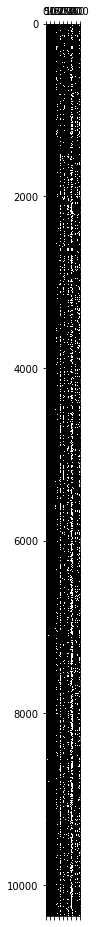

In [81]:
print("First subset of cleaned binary data, (samples,features) =", binaryChunk.shape)
plt.matshow(binaryChunk,cmap=plt.cm.gray,vmin=0,vmax=1)
plt.show()

In [80]:
np.unique(binaryChunk)

array([0., 1.])

In [85]:
bigChunk.shape

(10361, 537)

In [82]:
np.save("../data/binaryChunk-10361x399.npy",binaryChunk)
# save into data

In [86]:
#np.save("../data/featureSorter.npy",np.array(featureSorter))
#np.save("../data/sampleSorterA.npy",np.array(sampleSorterA))
np.save("../data/binaryChunkFeatures.npy",binaryChunkFeatures)

## Full Data to numeric Conversion

. collect possible data values. save them into .npy **DONE**

. make mapping between values and numbers. save default mapping into .npy **DONE**

. create new data-set with full data transformed into default values.

. create tutorial for others (domain name definitions, how to use new data, connections)

In [31]:
print("Only these attributes have no missing values")
for fi,f in enumerate(features):
  unq = np.unique(values[:,fi])
  if unq[0] != "":
    print(f," - ",unq[:7]," --- ",len(unq))

Only these attributes have no missing values
matching_weights  -  ['askiraubasouthernbornoidp' 'askiraubasouthernbornonondisplaced'
 'askiraubasouthernbornoreturnee' 'badecentralyobeidp'
 'badecentralyobenondisplaced' 'badecentralyobereturnee'
 'bamaeastbornoidp']  ---  189
WEIGHT_HH_DOMAIN  -  ['0.5230454736' '0.5289868736' '0.5358495449' '0.6495216065' '0.710219909'
 '0.7397515372' '0.7762024032']  ---  30
WEIGHT_HH_STATE  -  ['0.592578711' '0.6912005211' '0.7451927456' '1.8773562774' '3.7766253553'
 '3.8793947332' '4.414583631']  ---  9
HH_ALL  -  ['0.6645172403' '2.5056175788' '4.5717248076']  ---  3


In [32]:
def safe(coerce, val=None):
  def rt(x):
    try:
      return coerce(x)
    except ValueError:
      return val
  return rt

# guess the domain (integer, float between 0 and 1, categorical, etc.) from the unique values.
# if they are categorial ("string") and more than 300, then they are discarded.
# reason: lots of categories lead to loss of information. these categories could be for example
# the timestamp data which is not easy to make use of
catlimit = 150 # should be smaller than 189 to make "matching_weights" feature that has no missing value discarded.

def guess_feature_domain(fname,vls):
  vls = np.unique(vls)
  if vls[0] == '': # feature contains missing values. ignore them, as only a few specific ones have no missing values.
    vls = vls[1:]
  rs = None # there are no uncovered edge cases
  if len(vls) > catlimit and any(safe(float)(s)==None for s in vls): # not float or int
    rs = "largecat"
  elif all(safe(float)(s)!=None for s in vls): # float type
    rs = "float"
  else: #categorial
    rs = "cat%03d"%len(vls)
  return rs

Save .npy with all features, their domain name and explicit domain

In [33]:
# for each feature in "features" array (which is same ordered as in the csv and excel sheet)
# it's corresponding index in these arrays contains the feature name, the domain name ("int","float","large",..)
# and domain contents if the domain isn't "large"

allFeatureName = np.copy(features)
allDomainName = []
allDomainContents = []
allDefault = np.zeros(values.shape) # default mapping. will be finalized later

for fi,f in enumerate(features):
  if fi % 100 == 0:
    print("... [%d] ... " % fi)
  unq = np.unique(values[:,fi])
  dm = guess_feature_domain(features[fi],unq)
  allDomainName.append(dm)
  if dm=="largecat":
    allDomainContents.append(np.array([])) # discard
    # default values left to zero.
  elif dm=="float":
    allDomainContents.append(np.array(list(safe(float,-1)(x) for x in unq)))
    allDefault[:,fi] = np.array(list(safe(float,-1)(x) for x in values[:,fi]))
  else: # categorical
    allDomainContents.append(np.copy(unq))
    d = dict()
    for v in unq:
      d[v] = np.where(unq==v)[0] # values are mapped to their index
    d[""] = -1 #"" get's mapped to -1.
    allDefault[:,fi] = list(d[x] for x in values[:,fi])

# when saving the content. We map all the missing values to -1!

allDomainName = np.array(allDomainName)
allDomainContents = np.array(allDomainContents)

... [0] ... 
... [100] ... 
... [200] ... 
... [300] ... 
... [400] ... 
... [500] ... 
... [600] ... 
... [700] ... 
... [800] ... 
... [900] ... 


In [45]:
print("The following large categories are discarded. Their values will become 0 in the final data array.")

for fi,f in enumerate(features[:20]):
  if True or allDomainName[fi]=="largecat":
    print(allFeatureName[fi])
    print(allDomainName[fi])
    print(allDomainContents[fi])
    print(np.unique(values[:,fi]))
    print(allDefault[:,fi])
    print("------------")

The following large categories are discarded. Their values will become 0 in the final data array.
State
cat003
['' 'Adamawa' 'Borno' 'Yobe']
['Borno' 'Borno' 'Borno' 'Borno' 'Borno' 'Borno' 'Borno' 'Borno' 'Borno'
 'Borno' 'Borno' 'Borno' 'Borno' 'Borno' 'Borno']
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
------------
LGA
cat063
['' 'askirauba' 'bade' 'bama' 'bayo' 'biu' 'bursari' 'chibok' 'damaturu'
 'damboa' 'demsa' 'dikwa' 'fika' 'fufore' 'fune' 'ganye' 'geidam' 'girei'
 'gombi' 'gubio' 'gujba' 'gulani' 'guyuk' 'guzamala' 'gwoza' 'hawul'
 'hong' 'jada' 'jakusko' 'jere' 'kaga' 'kalabalge' 'karasuwa' 'konduga'
 'kukawa' 'kwayakusar' 'lamurde' 'machina' 'madagali' 'mafa' 'magumeri'
 'maiduguri' 'maiha' 'mayobelwa' 'michika' 'mobbar' 'monguno' 'mubinorth'
 'mubisouth' 'nangere' 'ngala' 'nganzai' 'nguru' 'numan' 'potiskum'
 'shani' 'shelleng' 'song' 'tarmua' 'toungo' 'yolanorth' 'yolasouth'
 'yunusari' 'yusufari']
['askirauba' 'askirauba' 'askirauba' 'askirauba' 'askirauba' 'askiraub

In [107]:
np.info(allDefault)

class:  ndarray
shape:  (10655, 947)
strides:  (7576, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fae89668010
byteorder:  little
byteswap:  False
type: float64


In [108]:
print(allDefault[:5,:5])

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [109]:
print(allDomainContents[40:85])

[array([-1.,  0.,  1.]) array([-1.,  0.,  1.]) array([-1.,  0.,  1.])
 array([-1.,  0.,  1.]) array([-1.,  0.,  1.]) array([-1.,  0.,  1.])
 array([-1.,  0.,  1.]) array([-1.,  0.,  1.]) array([-1.,  0.,  1.])
 array([-1.,  0.,  1.]) array([-1.,  0.,  1.]) array([-1.,  0.,  1.])
 array(['', 'No', 'Yes'], dtype='<U110')
 array(['', 'ARABIC', 'Aliyu Bello', 'Baali', 'Babur', 'Bali', 'Bare',
       'Barike damti', 'Barke damti', 'Bashina', 'Basiya', 'Bata',
       'Bateri', 'Batiye', 'Bazza', 'Bila', 'Bile', 'Bille', 'Bire',
       'Boga', 'Boka', 'Buga', 'Bula', 'Buzu', 'Bwatiye', 'Bwazza',
       'Chabbo', 'Cheba', 'Chibok', 'Dera', 'GAMARGU ', 'Gajiya',
       'Gamargu', 'Gangliah', 'Gilanda', 'Gude', 'Gudu', 'Guđe', 'Hausa',
       'HausaFulani', 'Hidi', 'Highi', 'Hona', 'Hulma', 'Hurukun',
       'Hushara', 'Ijasini', 'Jara', 'Jedi', 'Jedi ', 'Jehi', 'Jenjo',
       'Jihi', 'Jonjo', 'Jujo', 'Jukun', 'Kanakuru', 'Kanumbu', 'Kibaku',
       'Kiriya', 'Kliba', 'Koma', 'Koma damti', 'Kom

In [34]:
np.save("../data/allDomainName.npy",allDomainName)
np.save("../data/allDomainContents.npy",allDomainContents)
np.save("../data/allFeatureName.npy",allFeatureName)
np.save("../data/allDefault.npy",allDefault)

In [36]:
values.shape, allDefault.shape

((10656, 947), (10656, 947))

## Merging PiN-Scores (from other team) with our own allDefault data

In [7]:
allDomainName = np.load("../data/allDomainName.npy",allow_pickle=True)
allDomainContents = np.load("../data/allDomainContents.npy",allow_pickle=True)
allFeatureName = np.load("../data/allFeatureName.npy",allow_pickle=True)
allDefault = np.load("../data/allDefault.npy",allow_pickle=True)

print(allDefault.shape)

(10656, 947)


In [8]:
scoresRAW = []

with open("../data/PiN_scores.csv","rt") as csvf:
  # read feature names
  reader = csv.reader(csvf,delimiter=',', quotechar='"')
  scoresFeatures = np.array(next(reader))
  
  # read length of each content value. (only needed to know whethre valueis fille dor not)
  reader = csv.reader(csvf,delimiter=',', quotechar='"')
  scoresRAW = np.array([list(row) for row in reader])#[1:]

In [5]:
print(scoresRAW.shape)
print(scoresFeatures[:15],"..")
print(scoresRAW[0,:])

(10378, 46)
['' 'Ward' 'WASH_No_Water_Access' 'WASH_Below_15lpd'
 'WASH_No_Latrine_Access' 'WASH_Above_30min' 'WASH_No_Soap'
 'SHELTER_Inadequate' 'SHELTER_Damaged' 'SHELTER_Eviction_Risk'
 'SHELTER_No_Basic_Items' 'SHELTER_Many_Families' 'FOODSEC_FCS'
 'FOODSEC_RCSI' 'FOODSEC_SAFE'] ..
['1' 'hausarizadawa' '2.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '1.0'
 '0.0' '0.0' '0.0' '2.0' '1.0' '0.0' '0.0' '0.0' '0.0' '3.0' '0.0' '0.0'
 '0.0' '2.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '2.0' '1.0' '3.0' '3.0' '2.0' '0.0' '0.0' '0.0' '11.0' '5']


the row in the values array corresponding to the upper entry in scoresRAW is this:

In [7]:
values[1,:15]

array(['20180727T12:59:32223+01', '20180727T13:09:57808+01', 'Borno',
       'askirauba', 'hausarizadawa', 'Zadawa camp', 'zadawacamp',
       'zadawacamphausarizadawaaskiraubasouthern bornoborno',
       'southern borno', 'Internally Displaced Persons (IDPs)',
       'Household displaced since January 2009 and currently is not living in their village/area of origin',
       'Yes, agrees to interview', '1', '', '40'], dtype='<U110')

So essentially, the number in the first column of the csv corresponds to the index of that data-point in the values and allDefault array. We are going to use that to integrate both data-arrays.

Let N = 10656, n = 10378 and nf = 947. We have values and allDefault both of shape N x nf. We have scoresRAW of shape n x 46. We're going to create a new data frame that discards the non-responses which were thrown out before creating scoresRAW. Of the 46 columns, we'll keep all except the second column that is "Ward". That column is already in the allDefault encoded as numbers. Our new features will be \[row-index, ... allFeatureNames ..., ...scoreFeatures[2:]...\]. I.E. we have the row-index as the first feature. then we add all the nf=947 features from the original excel sheet and finally we add the informative calculated features from the PiN_scores.csv.

In [8]:
scoresFeatures[0:1].shape,allDomainName.shape,scoresFeatures[2:].shape

((1,), (947,), (44,))

In [10]:
scoresRAW.shape

(10378, 46)

In [11]:
# fill in a new value array and re-do importing process.
# for this data-set we use the prefix "wps" standing for "with PiN scores".
#we repeat the process from the initial data creation.

print("Creating raw data array of shape ",(scoresRAW.shape[0],allFeatureName.shape[0]+scoresFeatures.shape[0]-1),"...")

ints = np.array(list(map(int,scoresRAW[:,0])))
wpsValues = np.concatenate((scoresRAW[:,0:1],values[ints],scoresRAW[:,2:]),axis=1)

print(wpsValues.shape)
print("DONE")

Creating raw data array of shape  (10378, 992) ...
(10378, 992)
DONE


In [22]:
scoresFeatures[-10:-2]

array(['WEIGHT_WASH', 'WEIGHT_SHELTER', 'WEIGHT_FOODSEC', 'WEIGHT_LIVE',
       'WEIGHT_EDU', 'WEIGHT_HEALTH', 'WEIGHT_NUTRITION',
       'WEIGHT_PROTECTION'], dtype='<U26')

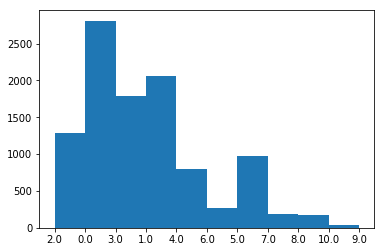

In [23]:
plt.hist(wpsValues[:,-10])
plt.show()

In [31]:
def safe(coerce, val=None):
  def rt(x):
    try:
      return coerce(x)
    except ValueError:
      return val
  return rt

catlimit = 150 # should be smaller than 189 to make "matching_weights" feature that has no missing value discarded.

def guess_feature_domain(fname,vls):
  vls = np.unique(vls)
  if vls[0] == '': # feature contains missing values. ignore them, as only a few specific ones have no missing values.
    vls = vls[1:]
  rs = None # there are no uncovered edge cases
  if len(vls) > catlimit and any(safe(float)(s)==None for s in vls): # not float or int
    rs = "largecat"
  elif all(safe(float)(s)!=None for s in vls): # float type
    rs = "float"
  else: #categorial
    rs = "cat%03d"%len(vls)
  return rs

wpsFeatureName = np.concatenate((np.array(['RowNo']),allFeatureName,scoresFeatures[2:]))
wpsDomainName = []
wpsDomainContents = []
wpsDefault = np.zeros(wpsValues.shape)

for fi,f in enumerate(wpsFeatureName):
  if fi % 100 == 0:
    print("... [%d] ... " % fi)
  unq = np.unique(wpsValues[:,fi])
  dm = guess_feature_domain(wpsFeatureName[fi],unq)
  wpsDomainName.append(dm)
  if dm=="largecat":
    wpsDomainContents.append(np.array([])) # discard
    # default values left to zero.
  elif dm=="float":
    wpsDomainContents.append(np.array(list(safe(float,-1)(x) for x in unq)))
    wpsDefault[:,fi] = np.array(list(safe(float,-1)(x) for x in wpsValues[:,fi]))
  else: # categorical
    wpsDomainContents.append(np.copy(unq))
    d = dict()
    for v in unq:
      d[v] = np.where(unq==v)[0] # values are mapped to their index
    d[""] = -1 #"" get's mapped to -1.
    wpsDefault[:,fi] = list(d[x] for x in wpsValues[:,fi])

# when saving the content. We map all the missing values to -1!

wpsDomainName = np.array(wpsDomainName)
wpsDomainContents = np.array(wpsDomainContents)

... [0] ... 
... [100] ... 
... [200] ... 
... [300] ... 
... [400] ... 
... [500] ... 
... [600] ... 
... [700] ... 
... [800] ... 
... [900] ... 


In [32]:
print(wpsFeatureName[-10:-2])

print(wpsDefault[:15,-10:-2])

print(wpsDomainName[-10:-2])
print(wpsDomainContents[-4])


['WEIGHT_WASH' 'WEIGHT_SHELTER' 'WEIGHT_FOODSEC' 'WEIGHT_LIVE'
 'WEIGHT_EDU' 'WEIGHT_HEALTH' 'WEIGHT_NUTRITION' 'WEIGHT_PROTECTION']
[[2.  1.  3.  3.  2.  0.  0.  0. ]
 [0.  3.  6.  2.  2.  0.  0.  0. ]
 [0.  3.  6.  2.  8.  0.  0.  0. ]
 [0.  3.  3.  0.  2.  0.  0.  0. ]
 [0.  1.  8.5 0.  2.  0.  0.  0. ]
 [3.  1.  6.5 5.  4.  4.  0.  0. ]
 [3.  3.  6.5 2.  4.  6.  0.  0. ]
 [3.  3.  6.5 7.  4.  6.  0.  0. ]
 [2.  0.  2.5 7.  0.  4.  0.  4. ]
 [1.  0.  2.5 5.  2.  4.  0.  0. ]
 [0.  1.  3.5 2.  7.  0.  0.  0. ]
 [0.  0.  2.5 2.  4.  4.  0.  0. ]
 [1.  0.  8.5 4.  4.  4.  0.  0. ]
 [3.  0.  7.5 2.  4.  4.  0.  0. ]
 [0.  1.  6.5 0.  2.  0.  0.  0. ]]
['float' 'float' 'float' 'float' 'float' 'float' 'float' 'float']
[0.]


In [20]:
wpsFeatureName[-50:]

array(['Language - Yungur', 'matching_weights', 'WEIGHT_IND_LGA',
       'WEIGHT_HH_DOMAIN', 'WEIGHT_HH_STATE', 'HH_ALL',
       'WASH_No_Water_Access', 'WASH_Below_15lpd',
       'WASH_No_Latrine_Access', 'WASH_Above_30min', 'WASH_No_Soap',
       'SHELTER_Inadequate', 'SHELTER_Damaged', 'SHELTER_Eviction_Risk',
       'SHELTER_No_Basic_Items', 'SHELTER_Many_Families', 'FOODSEC_FCS',
       'FOODSEC_RCSI', 'FOODSEC_SAFE', 'FOODSEC_Market',
       'FOODSEC_Agriculture', 'LIVE_Income_Decrease', 'LIVE_Debt',
       'LIVE_Coping', 'LIVE_Cash', 'EDU_Not_Attending',
       'EDU_Never_Attended_Formal', 'EDU_Barrier', 'EDU_No_Supplies',
       'HEALTH_Barrier', 'HEALTH_Child_No_Vaccines', 'HEALTH_Illness_2w',
       'HEALTH_Distance_2km', 'HEALTH_Delivery', 'NUTRITION',
       'PROTECTION_Explosives', 'PROTECTION_Incident_3m',
       'PROTECTION_No_Docs', 'PROTECTION_Movement',
       'PROTECTION_Missing_Members', 'WEIGHT_WASH', 'WEIGHT_SHELTER',
       'WEIGHT_FOODSEC', 'WEIGHT_LIVE', 'WEIGH

In [25]:
for fi,f in enumerate(wpsFeatureName[:20]):
  if True:
    print(wpsFeatureName[fi])
    print(wpsDomainName[fi])
    print(wpsDomainContents[fi])
    print(wpsValues[:5,fi])
    print(wpsDefault[:5,fi])
    print("------------")

RowNo
float
[1.000e+00 1.000e+01 1.000e+02 ... 9.997e+03 9.998e+03 9.999e+03]
['1' '2' '3' '4' '5']
[1. 2. 3. 4. 5.]
------------
start
largecat
[]
['20180727T12:59:32223+01' '20180727T13:39:53836+01'
 '20180727T13:23:51817+01' '20180727T13:10:13105+01'
 '20180727T09:45:20394+01']
[0. 0. 0. 0. 0.]
------------
end
largecat
[]
['20180727T13:09:57808+01' '20180727T14:18:14175+01'
 '20180727T13:34:51062+01' '20180727T13:22:02177+01'
 '20180727T10:12:35004+01']
[0. 0. 0. 0. 0.]
------------
State
cat003
['Adamawa' 'Borno' 'Yobe']
['Borno' 'Borno' 'Borno' 'Borno' 'Borno']
[1. 1. 1. 1. 1.]
------------
LGA
cat063
['askirauba' 'bade' 'bama' 'bayo' 'biu' 'bursari' 'chibok' 'damaturu'
 'damboa' 'demsa' 'dikwa' 'fika' 'fufore' 'fune' 'ganye' 'geidam' 'girei'
 'gombi' 'gubio' 'gujba' 'gulani' 'guyuk' 'guzamala' 'gwoza' 'hawul'
 'hong' 'jada' 'jakusko' 'jere' 'kaga' 'kalabalge' 'karasuwa' 'konduga'
 'kukawa' 'kwayakusar' 'lamurde' 'machina' 'madagali' 'mafa' 'magumeri'
 'maiduguri' 'maiha' 'mayobe

In [33]:
np.save("../data/wpsDomainName.npy",wpsDomainName)
np.save("../data/wpsDomainContents.npy",wpsDomainContents)
np.save("../data/wpsFeatureName.npy",wpsFeatureName)
np.save("../data/wpsDefault.npy",wpsDefault)

## 1-of-k coding

Replace coding of categorial data by 1-of-k vectors. Leads to an dramtic increase in number of dimensions, but is more accurate, as summing up along a categorial dimension will only sum up binary values and not ordinal numbers (which leads to semantic mistakes).

In [6]:
wpsDomainName = np.load("../data/wpsDomainName.npy",allow_pickle=True)
wpsDomainContents = np.load("../data/wpsDomainContents.npy",allow_pickle=True)
wpsFeatureName = np.load("../data/wpsFeatureName.npy",allow_pickle=True)
wpsDefault = np.load("../data/wpsDefault.npy",allow_pickle=True)

print(wpsDefault.shape)

(10378, 992)


In [5]:
print([len(x) for x in wpsDomainContents])

[10378, 0, 0, 3, 63, 0, 0, 0, 0, 10, 3, 3, 1, 4, 5, 78, 2, 2, 81, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 129, 69, 143, 34, 11, 11, 1, 3, 24, 24, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 5, 62, 0, 0, 9, 5, 3, 3, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 1, 7, 5, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 5, 22, 413, 324, 988, 782, 5, 3, 3, 3, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 8, 8, 8, 5, 8, 1, 8, 1, 5, 1, 7, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 1, 4, 14, 1, 10, 1, 6, 1, 4, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 12, 1, 136, 171, 5, 14, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [6]:
ls =[int(x[4:]) for x in wpsDomainName if x[:3]=="cat"]

In [7]:
sum(ls),len(ls)

(2049, 700)

In [8]:
sum([1 for x in wpsDomainName if x=="float"])

238

In [9]:
catPicker = np.array([xi for xi,x in enumerate(wpsDomainName) if x[:3]=="cat"])
numPicker = np.array([xi for xi,x in enumerate(wpsDomainName) if x=="float"])

In [10]:
toBeEncoded = wpsDefault[:,catPicker]+1 # missing vlaue = 0 and 2-based indices

In [11]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [12]:
#print(toBeEncoded)
print(enc.fit(toBeEncoded))
ohEncoded = enc.transform(toBeEncoded).toarray()
print(ohEncoded[3:14,:10],"...")
print(enc.feature_indices_[:15],"...") # contains the index at which each of the features start

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=True)
[[0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]] ...
[  0   4  68  79  83  87  89  92  95 101 104 107 110 113 116] ...


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:100: DeprecationWarning: The ``feature_indices_`` attribute was deprecated in version 0.20 and will be removed 0.22.
  warnings.warn(msg, category=DeprecationWarning)


In [15]:
enc.get_feature_names()

array(['x0_1.0', 'x0_2.0', 'x0_3.0', ..., 'x699_137.0', 'x699_138.0',
       'x699_139.0'], dtype=object)

In [16]:
# build new data matrix

oheDefault = np.concatenate((wpsDefault[:,numPicker],ohEncoded),axis=1)
#oheDomainName = n.concatenate((wpsDomainName[numPicker],wpsDomainName[catPicker]))

In [20]:
oheDefault.shape

(10378, 2882)

In [21]:
np.save("../data/oheDefault.npy",oheDefault)